<a href="https://colab.research.google.com/github/shrestha94sujan/stocks_analysis/blob/master/stocks_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('hello world of stocks!')

hello world of stocks!


**Installing yfinance api for importing the financial stuffs.**

In [2]:
!pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=1b18ce6fd57b252ca7f10c4253f9540bd156f857e06132e9c7a3b14aa77ea908
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


**Adding import statements.**

In [3]:
import yfinance as yf

# Just get the AAPL stocks, cuz frankly that's all i am interested in, lol
aapl = yf.Ticker('AAPL')

#get historical market data
hist = aapl.history(period='15y')

#if you wish to look at the entire historical data for last 15 years!
print(hist)

              Open    High     Low   Close     Volume  Dividends  Stock Splits
Date                                                                          
2005-05-09    4.61    4.63    4.54    4.57   88923800       0.00           0.0
2005-05-10    4.54    4.61    4.49    4.50  110065900       0.00           0.0
2005-05-11    4.35    4.41    4.09    4.40  510495300       0.00           0.0
2005-05-12    4.38    4.40    4.20    4.22  242560500       0.00           0.0
2005-05-13    4.23    4.36    4.21    4.30  175678300       0.00           0.0
...            ...     ...     ...     ...        ...        ...           ...
2020-05-04  288.39  292.90  285.55  292.37   33392000       0.00           0.0
2020-05-05  294.26  300.19  293.67  296.76   36937800       0.00           0.0
2020-05-06  299.65  302.42  298.06  299.82   35583400       0.00           0.0
2020-05-07  302.40  304.35  301.15  302.92   28803800       0.00           0.0
2020-05-08  305.64  310.35  304.29  310.13   3345960

**Historical charts that shows opening and closing stock prices.**

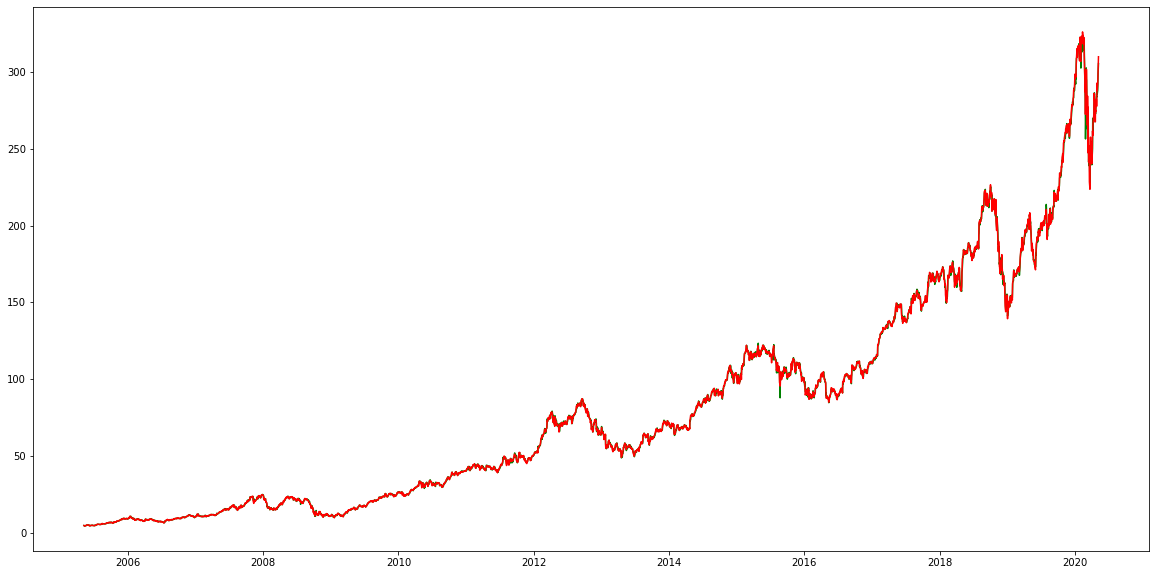

In [22]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn
from matplotlib.ticker import FixedFormatter, FixedLocator
%matplotlib inline

#Plot Open and Close prices.
plt.figure(figsize=(20, 10))
plt.plot(hist['Open'], color='green')
plt.plot(hist['Close'], color='red')



As we can see, the chart really doesn't help us draw a good understanding of the stock except show an increasing trend! That's where the Data modeling and clustering comes in. 

**Modeling our stock price data to meet requirements.**

[ 0.04  0.04 -0.05 ... -0.17 -0.52 -4.49]


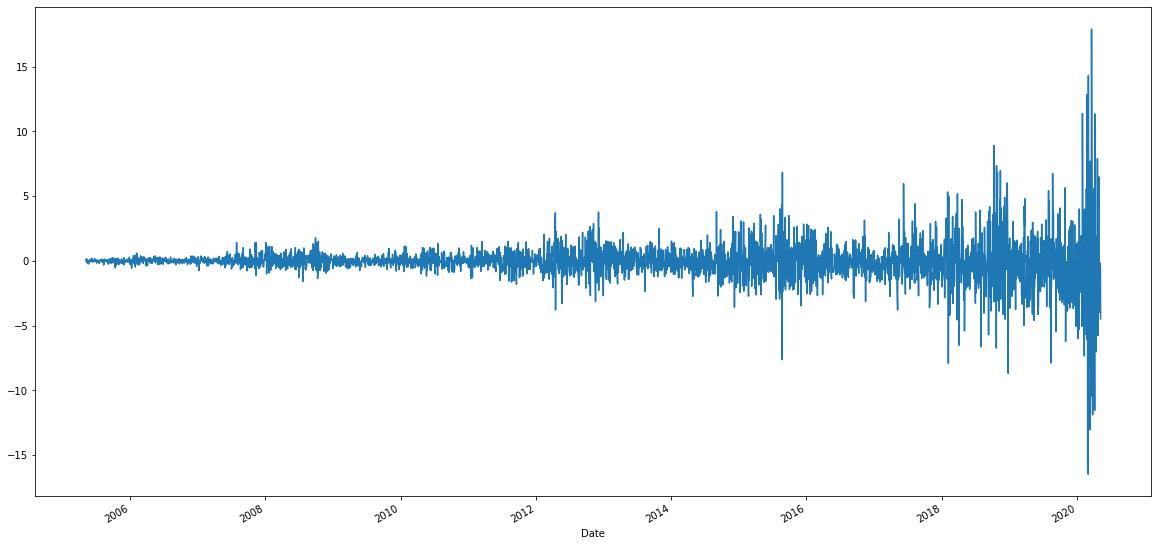

In [5]:
import pandas as pd
import numpy as np


#price change per day
pcd = np.asarray(hist['Open'] - hist['Close'])

print(pcd)  #printing out price change per day just becuz.

hist['PCD'] = pcd #adding PCD column with corresponding data to the "hist" dataframe
hist['PCD'].plot(figsize=(20, 10))  #plotting the PCD data wrt time series

**Observation:**  An important observation is that the volatility of the stock prices is increasing wrt time. As we further in time, we may notice even more volatility(fluctuation) in the stock prices!<br>Now, one might share an opinion that volatile stock prices is not a sign of a good stock, but another might share a different opinion!, that although high risk associated to volatility, the return might be very high depending on when the stock is purchased and sold. 

**Note:** Another important observation is, we can see occasional spikes here and there in "PCD". Now, this could have happened due to a number of different reasons, but we are only concerned whether it's also driven by certain date, year or month!

# &emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**KMEANS**

---



In [0]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

### **Finding optimal number of clusters**

### 1.   **Elbow Curve** method



In [0]:
X = hist[['PCD']]

kmeans_per_k = [KMeans(n_clusters=k, random_state=43).fit(X) 
                for k in range(1,15)]

inertias = [model.inertia_ for model in kmeans_per_k] #inertias for all models in kmeans_per_k

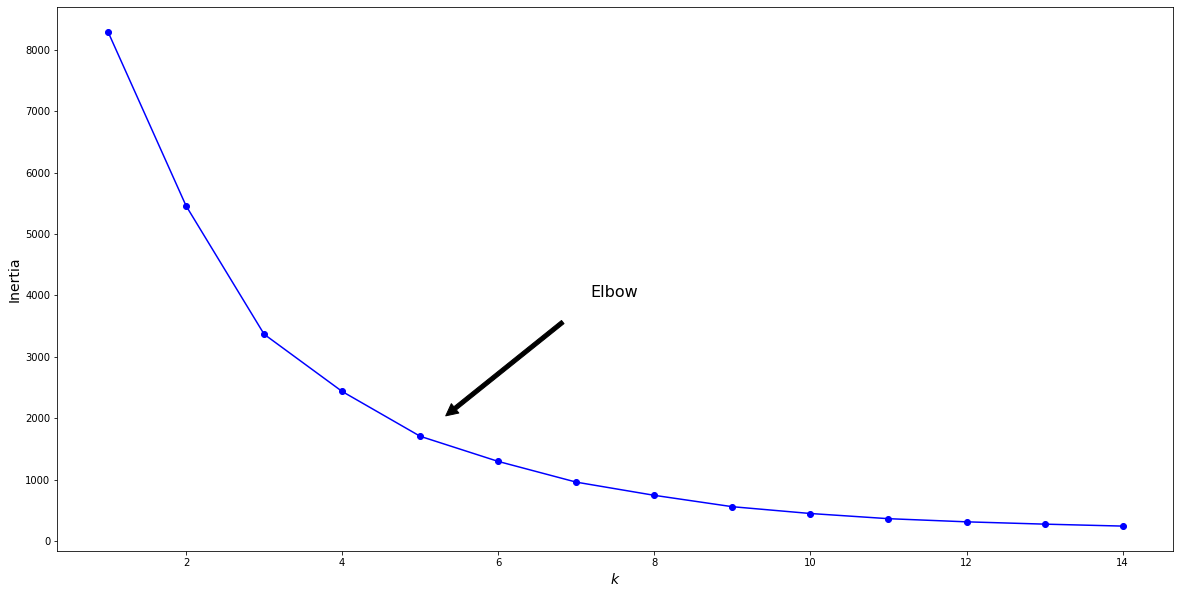

In [0]:
plt.figure(figsize=(20, 10))
plt.plot(range(1, 15), inertias, 'bo-')
plt.xlabel('$k$', fontsize=14)
plt.ylabel('Inertia', fontsize=14)
plt.annotate('Elbow',
             xy=(5, inertias[4]),
             xytext=(0.5, 0.5),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.15)
            )
plt.show()

### **Observation**
We see that there is an elbow at $k=5$, which means that less clusters than that would be bad, and more clusters would not help much and might cut clusters in half.

So $k=5$ is a pretty good choice.

### **2.    Silhouette score vs 𝑘**

The silhouette coefficient can vary between -1 and +1:

*   A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters.
*   A coefficient close to 0 means that it is close to a cluster boundary.
*   A coefficient close to -1 means that the instance may have been assigned to the wrong cluster.




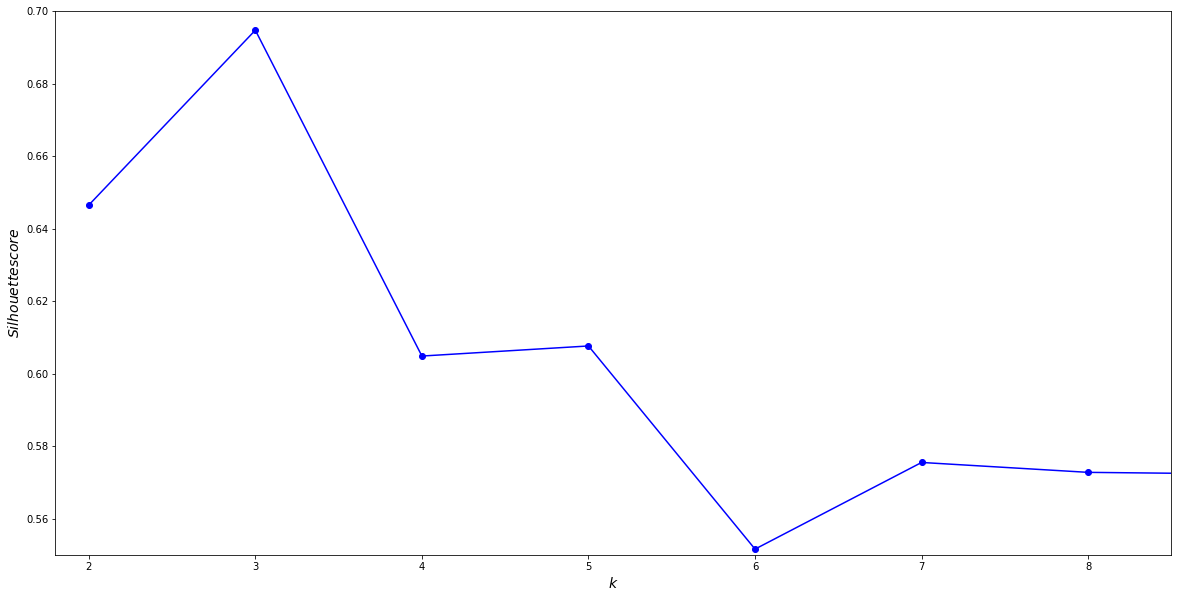

In [10]:
silhouette_scores = [silhouette_score(X, model.labels_) 
                      for model in kmeans_per_k[1:]]    #silhouette scores for models in kmeans_per_k starting at index=1

plt.figure(figsize=(20, 10))
plt.plot(range(2, 15), silhouette_scores, 'bo-')  #setting the range for plot equal to the range used for kmeans.
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$Silhouette score$', fontsize=14)
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()





## **Observation**

This visualization is much than the previous one: in particular, although it confirms that $k$ = 3 is a very goo choice, but it also underline the fact that $k$ = 5 is not that bad either.

## **Silhouette Diagram** 

An even more informative visualization is given when we plot every instance's silhouette coefficient, sorted by the cluster they are assigned to and by the value of the coefficient.

This is called a silhouette diagram.

Each diagram contains one knife shape per cluster. The shape’s height indicates the number of instances the cluster contains, and its width represents the sorted silhouette coefficients of the instances in the cluster (wider is better). The dashed line indicates the mean silhouette coefficient.

### **Note:**
Since we got the best results for the optimal $k$ at $k$ = 3 and $k$ = 5, we will select this range plus a few more $k$ to find the best optimal $k$.

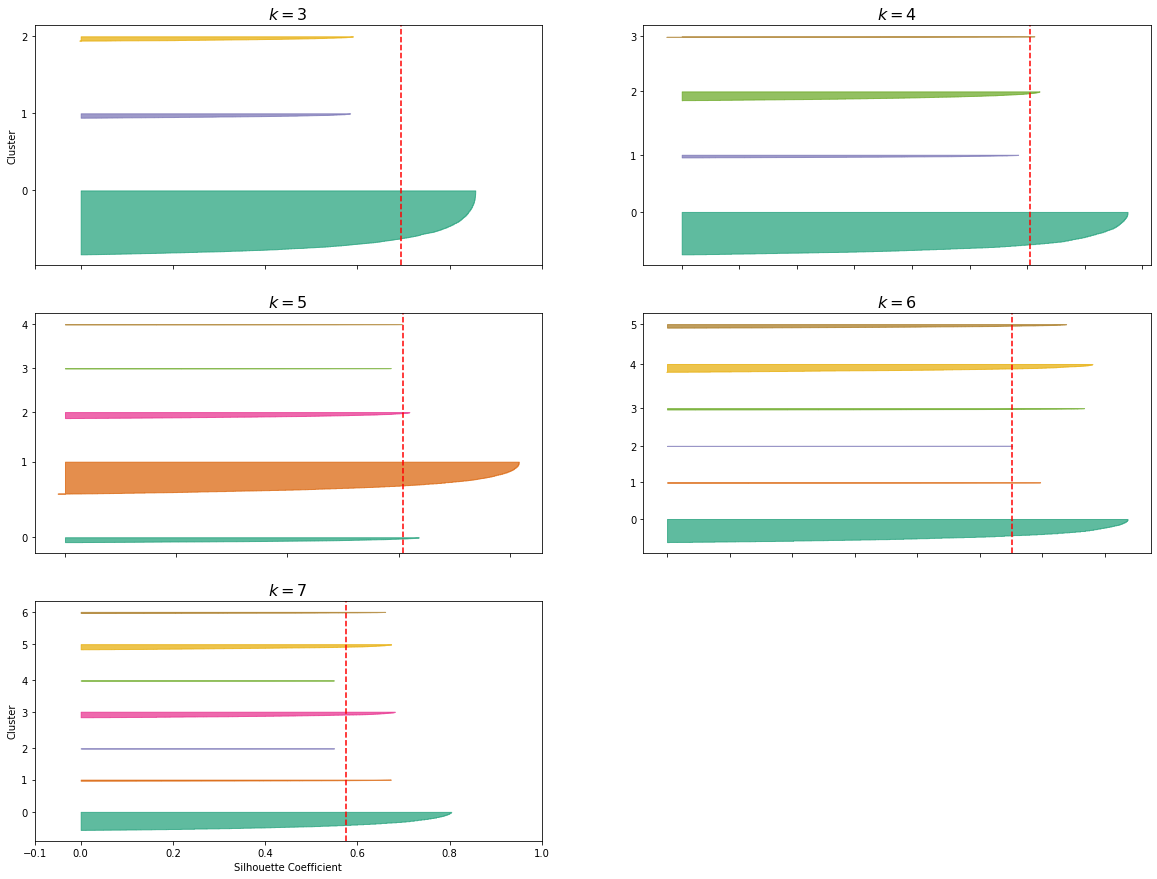

In [39]:
plt.figure(figsize=(20,15))

for k in (3, 4, 5, 6 ,7):
  plt.subplot(3, 2, k - 2)

  y_pred = kmeans_per_k[k - 1].labels_ # using k - 1 because its a list and k = 3 is in 3-1 = 2nd position in the list.
  silhouette_coefficients = silhouette_samples(X, y_pred)

  padding = len(X)
  pos = padding
  ticks = []

  for i in range(k):
    coeffs = silhouette_coefficients[y_pred == i]
    coeffs.sort()

    color = mpl.cm.Dark2(i / k)
    plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0 , coeffs,
                      facecolor=color, edgecolor=color, alpha=0.7)
    ticks.append(pos + len(coeffs))
    pos += len(coeffs) + padding

  plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
  plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
  if k in (3, 7):
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel("Cluster")

  if k == 7:
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Silhouette Coefficient")
  else:
    plt.tick_params(labelbottom=False)

  plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
  plt.title("$k={}$".format(k), fontsize=16)

plt.show()


## **Observation: Silhouette Diagram**

The vertical dashed lines represent the silhouette score for each number of clusters.

When most of the instances in a cluster have a lower coefficient than this score (i.e., if many of the instances stop short of the dashed line, ending to the left of it), then the cluster is rather bad since this means its instances are much too close to other clusters. We can see that when $k$ = 3, we get bad clusters.

And when $k$ = 4 or $k$ = 5 or $k$ = 7, the clusters look pretty good: most instances extend upto or beyond the dashed line, to the right and closer to 1.0. 

But, when $k$ = 6, the clusters look the best: all the instances extend upto or beyond the dashed line, to the right and closer to 1.0 and all the cluster have similar sizes. So, even though the overall silhouette score from $k$ = 5 is greater than $k$ = 6, it seems like $k$ = 6 is a better choice for us.